In [1]:
import tensorflow as tf

In [ ]:
!pip install fasttext

In [2]:
from vocab import MixVocab, Vocab
mixvocab = MixVocab.load('dataset/mix_vocab.json')
#vocab = Vocab.load('dataset/vocab.json')
#vocab.load_embeddings('dataset/vocab_embeddings.pkl')
mixvocab.load_embeddings('dataset/mix_vocab_embeddings.pkl')

In [3]:
from sklearn.utils import shuffle
from dataset import Dataset
import numpy as np
def create_dataset(is_train):
        if is_train:
            dataset = Dataset.create_from_file('dataset/train.jsonl')
        else:
            dataset = Dataset.create_from_file('dataset/test.jsonl')
        code_data, comment_data, Y = [], [], []
        for example in dataset.train_batch_iter(1, shuffle=False):

            new_code_tokens =mixvocab.token.words2indices(example.new_code_tokens)[0]
            src_tokens = mixvocab.token.words2indices(example.src_tokens)[0]
            tgt_tokens = mixvocab.token.words2indices(example.tgt_tokens)[0]

             # new code and source(old) tokens --> inconsistency --> positive example
            code_data.append(new_code_tokens)
            comment_data.append(src_tokens)
            Y.append(1)
            # new code and target(new) tokens ---> consistency --> negative example
            code_data.append(new_code_tokens)
            comment_data.append(tgt_tokens)
            Y.append(0)
        return code_data, comment_data, Y

In [4]:
test_codeX, test_commentX, testY = create_dataset(is_train=False)
codeX, commentX, Y = create_dataset(is_train=True)

INFO:root:loading 9673 samples
INFO:root:loading 85657 samples


In [5]:
codeX = np.array(codeX)
commentX = np.array(commentX)
Y = np.array(Y)
length = list(map(len, codeX))
q3 = np.quantile(length, 0.75)
filter_length = length <= q3
codeX = codeX[filter_length]
commentX = commentX[filter_length]
Y = Y[filter_length]
max_code_length = int(q3)

print(len(codeX))

128716


In [6]:
test_codeX = np.array(test_codeX)
test_commentX = np.array(test_commentX)
testY = np.array(testY)
length = list(map(len, test_codeX))
q3 = np.quantile(length, 0.75)
filter_length = length <= q3
test_codeX = test_codeX[filter_length]
test_commentX = test_commentX[filter_length]
testY = testY[filter_length]
max_code_length = int(q3)

print(len(test_codeX))

14520


In [7]:
max_comment_length = max(map(len, commentX))
print(max_code_length, max_comment_length)

188 52


In [8]:
codeX = tf.keras.preprocessing.sequence.pad_sequences(
    codeX
)
test_codeX = tf.keras.preprocessing.sequence.pad_sequences(
    test_codeX
)

In [9]:
commentX = tf.keras.preprocessing.sequence.pad_sequences(
    commentX
)
test_commentX = tf.keras.preprocessing.sequence.pad_sequences(
    test_commentX
)

In [ ]:
# just comment this cell if you use GPU
import os
tf.keras.backend.clear_session()

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

INFO:absl:Entering into master device scope: /job:worker/replica:0/task:0/device:CPU:0


INFO:tensorflow:Initializing the TPU system: grpc://10.5.197.50:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.5.197.50:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU')]


In [ ]:
from tensorflow.keras import layers

# just comment this if you use GPU
strategy = tf.distribute.TPUStrategy(resolver)

# just comment this if you use GPU
with strategy.scope():
  vocab_size = len(mixvocab.token) 
  embedding_size = 300
  embedding_matrix = mixvocab.token.embeddings

  hidden_size = 64

  code_input = tf.keras.Input((None,), name='code')
  comment_input = tf.keras.Input((None, ), name='comment')
  code_features = layers.Embedding(input_dim=vocab_size,
                                  output_dim=embedding_size,
                                  embeddings_initializer=
                                  tf.keras.initializers.Constant(embedding_matrix),
                                  trainable=False)(code_input)
  comment_features = layers.Embedding(input_dim=vocab_size,
                                  output_dim=embedding_size,
                                  embeddings_initializer=
                                  tf.keras.initializers.Constant(embedding_matrix),
                                  trainable=False)(comment_input)

  dropout_rate = 0.4
  code_encoder = layers.Bidirectional(layers.LSTM(hidden_size, dropout=dropout_rate))(code_features)
  comment_encoder = layers.Bidirectional(layers.LSTM(hidden_size, dropout=dropout_rate))(comment_features)

  encoder = layers.Concatenate()([code_encoder, comment_encoder])

  encoder_dense = layers.Dense(hidden_size * 4, activation='relu')(encoder)

  output = layers.Dense(1, name='out')(encoder_dense)

  model = tf.keras.Model(inputs=[code_input, comment_input],
                        outputs=[output])
  #model.build()
  model.summary()
  model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(0.1),
              metrics=['accuracy'])

INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
code (InputLayer)               [(None, None)]       0                                            
__________________________________________________________________________________________________
comment (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, None, 300)    13373400    code[0][0]                       
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, None, 300)    13373400    comment[0][0]                    
_______________________________________________________________________________________

In [ ]:
history = model.fit({'code': codeX, 'comment':commentX}, {'out':Y}, epochs=10,
                    shuffle= True, batch_size=32, validation_split=0.2)

Epoch 1/3
   1/3218 [..............................] - ETA: 2:20:06 - loss: 0.6913 - accuracy: 0.4062WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0023s vs `on_train_batch_end` time: 0.0269s). Check your callbacks.


3217/3218 [============================>.] - ETA: 0s - loss: 0.7410 - accuracy: 0.5000WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0018s vs `on_test_batch_end` time: 0.0171s). Check your callbacks.


3218/3218 [==============================] - 112s 35ms/step - loss: 0.7410 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/3
3218/3218 [==============================] - 107s 33ms/step - loss: 0.6954 - accuracy: 0.5000 - val_loss: 0.6938 - val_accuracy: 0.5000
Epoch 3/3
3218/3218 [==============================] - 106s 33ms/step - loss: 0.6953 - accuracy: 0.5000 - val_loss: 0.6953 - val_accuracy: 0.5000


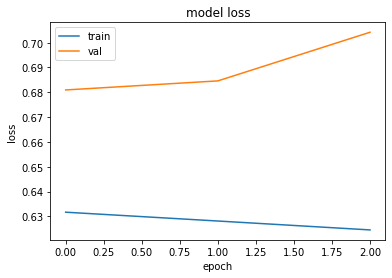

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
print("Evaluate on test data")
results = model.evaluate({'code': test_codeX, 'comment':test_commentX}, {'out':testY})
print("test loss, test acc:", results)